In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
!nvidia-smi

Tue May 23 00:01:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:01:00.0  On |                  N/A |
| 70%   33C    P8               39W / 350W|    423MiB / 24576MiB |     21%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions and General Audio Datasets (CREMA, TESS,  RAVDASS, ETC)

In [3]:
train_audio = pkl.load(open('./data/c4ai_clip/train_audio.pkl', "rb"))[['path', 'label']]
test_audio = pkl.load(open('./data/c4ai_clip/test_audio.pkl', "rb"))[['path', 'label']]

In [4]:
#!unzip ./data/c4ai_clip/audio_emo_resampled.zip -d ./audio

In [5]:
def norm_labels(x):
    if x == "afraid":
        return "fear"
    elif x == "angry":
        return "anger"
    elif x == "disgusted":
        return "disgust"
    elif x == "sad":
        return "sadness"
    else:
        return x

In [6]:
train_audio["label"] = train_audio["label"].apply(norm_labels)
test_audio["label"] = test_audio["label"].apply(norm_labels)

In [7]:
pd.concat([train_audio,test_audio]).groupby("label").count()

,path
label,
anger,1863
disgust,1863
fear,1863
joy,2055
neutral,1583
sadness,1863
surprise,592


## Load Meld and Iemocap

In [8]:
train_df_erc = pd.read_csv("train_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
train_df_erc["path"] = train_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
train_df_erc

,text,label,path
0,"OK, we got the cole slaw, we got the buns...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
1,"OK, we got the cole slaw, we got the buns... [...",disgust,/home/vmachado/Documents/multimodal-datasets/M...
2,"OK, we got the cole slaw, we got the buns... W...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
3,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
4,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
...,...,...,...
15862,"Right. Um, Thanks for asking, though. I mean, ...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15863,"God, that's like a whole problem with like-- B...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15864,"if you ever come out to Montgomery, I mean, yo...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
15865,"call up the Sprint call center and, uh, you kn...",neutral,/home/vmachado/Documents/multimodal-datasets/I...


In [9]:
test_df_erc = pd.read_csv("test_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
test_df_erc["path"] = test_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
test_df_erc

,text,label,path
0,"Brian, I need help.",sadness,/home/vmachado/Documents/multimodal-datasets/I...
1,"Brian, I need help. [CTX] Babe, I don't know w...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
2,"Babe, I don't know what to tell you. Don't gi...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
3,I don't--I'm just--I'm thinking maybe I should...,anger,/home/vmachado/Documents/multimodal-datasets/I...
4,"Well, of course not, but what are you going to...",anger,/home/vmachado/Documents/multimodal-datasets/I...
...,...,...,...
2753,Cantaloupe juice. Exactly. [CTX] You've tasted...,surprise,/home/vmachado/Documents/multimodal-datasets/M...
2754,Exactly. You've tasted it? You've tasted it. [...,neutral,/home/vmachado/Documents/multimodal-datasets/M...
2755,You've tasted it? You've tasted it. Uh huh. [C...,anger,/home/vmachado/Documents/multimodal-datasets/M...
2756,"Uh huh. Oh, you've tasted it. [CTX] You can ke...",neutral,/home/vmachado/Documents/multimodal-datasets/M...


In [10]:
test_df_erc["source"] = test_df_erc["path"].apply(lambda x: "meld" if "MELD" in x else "iemocap")
test_df_erc

,text,label,path,source
0,"Brian, I need help.",sadness,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
1,"Brian, I need help. [CTX] Babe, I don't know w...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
2,"Babe, I don't know what to tell you. Don't gi...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
3,I don't--I'm just--I'm thinking maybe I should...,anger,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
4,"Well, of course not, but what are you going to...",anger,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
...,...,...,...,...
2753,Cantaloupe juice. Exactly. [CTX] You've tasted...,surprise,/home/vmachado/Documents/multimodal-datasets/M...,meld
2754,Exactly. You've tasted it? You've tasted it. [...,neutral,/home/vmachado/Documents/multimodal-datasets/M...,meld
2755,You've tasted it? You've tasted it. Uh huh. [C...,anger,/home/vmachado/Documents/multimodal-datasets/M...,meld
2756,"Uh huh. Oh, you've tasted it. [CTX] You can ke...",neutral,/home/vmachado/Documents/multimodal-datasets/M...,meld


In [11]:
disg = train_df_erc[train_df_erc["label"] == "disgust"].sample(2000, replace=True, random_state=0)
fear = train_df_erc[train_df_erc["label"] == "fear"].sample(2000, replace=True, random_state=0)
sadness = train_df_erc[train_df_erc["label"] == "sadness"].sample(1500, replace=True, random_state=0)
surprise = train_df_erc[train_df_erc["label"] == "surprise"].sample(1500, replace=True, random_state=0)

In [12]:
train_df_erc_resampled = pd.concat([train_df_erc, disg, fear, surprise, sadness]).reset_index(drop=True)

In [13]:
train_df_erc_resampled.groupby("label").count()

,text,path
label,,
anger,3510,3510
disgust,2273,2273
fear,2298,2298
joy,2937,2937
neutral,6033,6033
sadness,3022,3022
surprise,2794,2794


## Join datasets (audio)

In [14]:
from os.path import exists

In [15]:
df_train = pd.concat([train_df_erc_resampled, train_df_erc_resampled, train_audio.assign(text=[None for _ in range(len(train_audio))]), test_audio.assign(text=[None for _ in range(len(test_audio))])], axis=0).reset_index(drop=True)

In [16]:
df_train = train_df_erc_resampled

In [17]:
df_dev = test_df_erc

In [18]:
df_train

,text,label,path
0,"OK, we got the cole slaw, we got the buns...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
1,"OK, we got the cole slaw, we got the buns... [...",disgust,/home/vmachado/Documents/multimodal-datasets/M...
2,"OK, we got the cole slaw, we got the buns... W...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
3,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
4,"Wait a minute, hold it. Johnson! Will you com...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
...,...,...,...
22862,No. You want me to get some champagne? [CTX] No.,sadness,/home/vmachado/Documents/multimodal-datasets/I...
22863,"Oh God, I hate my job, I hate it, I hate my jo...",sadness,/home/vmachado/Documents/multimodal-datasets/M...
22864,"There's people that have given more though, yo...",sadness,/home/vmachado/Documents/multimodal-datasets/I...
22865,So sad. It just feels like I was talking to hi...,sadness,/home/vmachado/Documents/multimodal-datasets/I...


In [19]:
len(df_dev)

2758

In [20]:
df_train[df_train["path"] == None]

,text,label,path


In [21]:
df_dev[df_dev["path"] == None]

,text,label,path,source


In [22]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(df_train['label'].unique())

LabelEncoder()

In [23]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [24]:
import torch
import torch.nn as nn

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.2, contrast_mode='all',
                 base_temperature=0.2):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None, temperature=None, base_temperature=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        if temperature == None:
            temperature = self.temperature
        if base_temperature == None:
            base_temperature = self.base_temperature
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 1]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (temperature/base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

## MFCC Extractor and KMeans Hidden units

In [25]:
import hashlib
import torch
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import numpy as np
from tqdm import tqdm
import functools
import math
import pickle as pkl
import os

sample_rate = 16000
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

MFCC_PARAMS = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

PITCH_PARAMS = {
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "sample_rate": sample_rate,
}

def get_feats(x, sr, params=MFCC_PARAMS, params_pitch=PITCH_PARAMS):
    pitch = torchaudio.functional.compute_kaldi_pitch(x, **params_pitch).squeeze(dim=0)
    
    x = x.view(1, -1)

    mfccs = torchaudio.compliance.kaldi.mfcc(
        x,
        **params
    )  # (time, freq)
    
    try:
        mfccs = torch.cat([mfccs, pitch], dim=-1)
    except:
        mfccs = torch.cat([mfccs, torch.Tensor(np.zeros((mfccs.shape[0], 2)))], dim=-1)
    
    mfccs_z = torch.Tensor(np.zeros(((mfccs.shape[0] // 2) + 1, mfccs.shape[1])))
    
    for i in range(len(mfccs) // 2): # Max pooling over time to reduce sequence size
        if np.linalg.norm(mfccs[2*i][:-2]) > np.linalg.norm(mfccs[(2*i) + 1][:-2]):
            mfccs_z[i] = mfccs[2*i]
        else:
            mfccs_z[i] = mfccs[(2*i) + 1]
            
    mfccs = mfccs_z.transpose(0, 1)  # (freq, time)
    deltas = torchaudio.functional.compute_deltas(mfccs)
    ddeltas = torchaudio.functional.compute_deltas(deltas)
    concat = torch.cat([mfccs, deltas, ddeltas], dim=0)
    concat = concat.transpose(0, 1).contiguous()
    
    return concat

def mfcc_feature_extractor(path, desired_sr=16000, cache="./preprocessed_audio_cache_new"):
    hashed_name = hashlib.md5(path.encode('utf-8')).hexdigest()
    hashed_path = cache + '/' + f"{hashed_name}.bin"
    with torch.no_grad():
        if os.path.isfile(hashed_path):
            return torch.load(hashed_path)
        else:
            waveform, sample_rate = torchaudio.load(path, normalize=True, channels_first=True)
            waveform = waveform.float()
            #print(waveform)
            if len(waveform.shape) == 2:
                waveform = torch.mean(waveform, dim=0).unsqueeze(dim=0)

            if sample_rate != desired_sr:
                transform = torchaudio.transforms.Resample(sample_rate, desired_sr)
                waveform = transform(waveform)

            mfcc = get_feats(waveform, desired_sr)
            torch.save(mfcc, hashed_path)
            return mfcc

In [26]:
def get_data_cluster(path):
    mfcc_audio = mfcc_feature_extractor(path)
    return mfcc_audio

In [27]:
#!rm ./preprocessed_audio_cache_new/*.bin

In [28]:
get_data_cluster("./audio/audio_emo/tess.woman.sad.5.wav")

tensor([[-6.8122e+01, -1.7865e+01,  1.0283e+01,  ..., -6.5504e-01,
         -1.1218e-02, -4.5475e-14],
        [-5.4309e+01, -3.1988e+01, -7.8407e+00,  ..., -1.2515e+00,
         -2.1313e-02, -4.5475e-14],
        [-4.4171e+01, -3.9444e+01,  5.1471e+00,  ..., -1.0251e+00,
         -1.3131e-02, -4.5475e-14],
        ...,
        [-6.6382e+01, -1.6293e+01,  1.4263e+01,  ..., -6.5024e-01,
         -8.0680e-02, -1.9203e+01],
        [-6.6557e+01, -1.7831e+01,  9.7851e+00,  ..., -1.0635e+00,
         -8.5602e-02, -1.4936e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -9.0566e-01,
         -4.9540e-02, -4.2674e+00]])

In [29]:
get_data_cluster("./audio/audio_emo/tess.woman.sad.6.wav").shape

torch.Size([111, 45])

## Add mask to Transformer, try learned positional embeddings

In [30]:
!pip install vector-quantize-pytorch

In [31]:
from joblib import Parallel, delayed
from vector_quantize_pytorch import VectorQuantize
from vector_quantize_pytorch import ResidualVQ

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class AudioEncoderMFCCHU(nn.Module):

    def __init__(self, 
                 clusterization_model, 
                 vocab_size,
                 cluster_data_mean,
                 cluster_data_std,
                 emb_dim=768, 
                 n_layers=6, 
                 max_length=800,
                 raw_features_size=45,
                 nheads=8, 
                 dropout=0.2):
        super(AudioEncoderMFCCHU, self).__init__()
        
        self.cluster_data_mean = cluster_data_mean
        self.cluster_data_std = cluster_data_std
        self.clusterization_model = clusterization_model
        self.vocab_size = vocab_size
        
        self.max_length = max_length
        
        self.vq = ResidualVQ(
            dim = raw_features_size,
            codebook_size = self.vocab_size,
            codebook_dim = 8,
            num_quantizers = 4,
            kmeans_init = True,
            kmeans_iters = 100,
        )
        
        self.pos_encoder = PositionalEncoding(emb_dim, dropout) # max batch size
        self.project = nn.Sequential(nn.Linear(raw_features_size, emb_dim), nn.GELU(), nn.Dropout(p=dropout), nn.Linear(emb_dim, emb_dim))
        
        self.emb_dim = emb_dim
        self.dropout = dropout
        self.transf_layer = nn.TransformerEncoderLayer(d_model=emb_dim, dim_feedforward=emb_dim*4, nhead=nheads, batch_first=True)
        self.transf_enc = nn.TransformerEncoder(self.transf_layer, num_layers=n_layers, norm=nn.LayerNorm(emb_dim))
        
        self.norm_mfcc = nn.LayerNorm(raw_features_size)

    def preprocess_audio(self, path):
        with torch.no_grad():
            mfcc = (mfcc_feature_extractor(path) - self.cluster_data_mean) / (self.cluster_data_std + 1e-10)
        
        mfcc = self.norm_mfcc(mfcc.to(0))
        qtz_mfcc, _, vq_loss = self.vq(mfcc)
        l = len(qtz_mfcc)
        att_mask = torch.ones((self.max_length, 1)).to(0)
        
        if l > self.max_length:
            qtz_mfcc = qtz_mfcc[:self.max_length]
        elif l < self.max_length:
            mask_idx = torch.Tensor([i + l for i in range(self.max_length - l)]).long().to(0)
            att_mask = att_mask.index_fill_(0, mask_idx, 0.0)
            repeat = torch.zeros((self.max_length - l, qtz_mfcc.shape[1])).to(0)
            qtz_mfcc = torch.cat([qtz_mfcc, repeat], dim=0)
            
        qtz_mfcc = qtz_mfcc.unsqueeze(dim=0)
        att_mask = att_mask.unsqueeze(dim=0).squeeze(dim=-1)
        return qtz_mfcc, att_mask, vq_loss
    
    def forward(self, audio_paths):
        
        tokens_and_loss = list(map(self.preprocess_audio,audio_paths))
        tokens = [t for t, _, _ in tokens_and_loss]
        att_masks = [a for _, a, _ in tokens_and_loss]
        vq_loss = torch.cat([l for _, _, l in tokens_and_loss]).to(0).mean()
        
        tks_tensor = torch.cat(tokens, axis=0)
        att_masks = torch.cat(att_masks, axis=0)
        
        assert len(tks_tensor) == len(audio_paths)
            
        #att_masks = F.dropout(att_masks, p=self.dropout, training=self.training)
        
        tks_tensor_lens = 1/torch.sum(att_masks, dim=-1)
        tks_tensor_lens = tks_tensor_lens.unsqueeze(dim=0).T

        emb = self.project(tks_tensor)
        emb = self.pos_encoder(emb)

        x = self.transf_enc(emb, src_key_padding_mask=att_masks)
        x = tks_tensor_lens * torch.sum(x, dim=1)
        
        return x, vq_loss

In [32]:
class AudioCLIP(nn.Module):

    def __init__(self, 
                 audio_encoder, 
                 out_features_audio=16, 
                 wide_proj=1024, 
                 proj_size=128, 
                 rate=0.1):
        super(AudioCLIP, self).__init__()

        self.audio_encoder = audio_encoder
        self.wide_proj = nn.Sequential(nn.Linear(out_features_audio, wide_proj), nn.GELU(), nn.Linear(wide_proj, wide_proj))
        self.compressed_proj = nn.Linear(wide_proj, proj_size)
        self.rate = rate
        
    def forward(self, paths):
        
        x, vq_loss = self.audio_encoder(paths)
        clf_emb = F.normalize(self.wide_proj(x), dim=-1)
        x1 = F.dropout(clf_emb, p=self.rate, training=self.training)
        x1 = F.normalize(self.compressed_proj(x1), dim=-1)
        
        return x1, clf_emb, vq_loss

In [33]:
df_train['label'].unique()

array(['neutral', 'disgust', 'anger', 'sadness', 'joy', 'surprise',
       'fear'], dtype=object)

In [34]:
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_dev)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=False)

In [35]:
import torchaudio
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
import pickle
gc.enable()

In [36]:
gc.collect()

0

In [37]:
import numpy as np
import faiss


class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [38]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups


def calc_lr(step, dim_embed, warmup_steps):
    return dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))

# add cluster ensembles

In [39]:
#mk = Parallel(n_jobs=12)(delayed(get_data_cluster)(x) for x in df_train["path"])
#mk = [len(m) for m in mk]

In [40]:
#np.arange(0.1, 1, 0.05)

In [41]:
#np.quantile(mk, q = 0.85)

In [42]:
#np.quantile(mk, q = np.arange(0.1, 1, 0.05))

In [43]:
X = Parallel(n_jobs=12)(delayed(get_data_cluster)(x) for x in df_train["path"])
X = torch.cat(X, dim=0)

mean = torch.mean(X, axis=0)
std = torch.std(X, axis=0)

"""
mean = torch.mean(X, axis=-0)
std = torch.std(X, axis=0)

X = (X - mean)/(std+1e-5)

N_CLUSTERS = 100
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS,
                          random_state=0,
                          batch_size=300_000,
                          n_init=1,
                          init="k-means++").fit(X)
                          
# DEV 

N_CLUSTERS_P = [32, 64, 128, 256, 512]

from sklearn.cluster import MiniBatchKMeans
inertias = []
for k in N_CLUSTERS_P:
    kmeans = MiniBatchKMeans(n_clusters=k,
                          random_state=0,
                          batch_size=300_000,
                          max_iter=1000000,
                          n_init=1,
                          init="k-means++").fit(X)
    kmeans.fit(X) 
    inertias.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(N_CLUSTERS_P, inertias)
plt.show()

X_t = list(map(get_data_cluster, df_train["path"]))
print(pd.DataFrame([x.numpy().shape for x in X_t]).describe())
print(pd.DataFrame([x.numpy().shape for x in X_t]).quantile(q=0.95))
# 800 max length will cover most of train samples
# best cluster number == 128
"""

'\nmean = torch.mean(X, axis=-0)\nstd = torch.std(X, axis=0)\n\nX = (X - mean)/(std+1e-5)\n\nN_CLUSTERS = 100\nkmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS,\n                          random_state=0,\n                          batch_size=300_000,\n                          n_init=1,\n                          init="k-means++").fit(X)\n                          \n# DEV \n\nN_CLUSTERS_P = [32, 64, 128, 256, 512]\n\nfrom sklearn.cluster import MiniBatchKMeans\ninertias = []\nfor k in N_CLUSTERS_P:\n    kmeans = MiniBatchKMeans(n_clusters=k,\n                          random_state=0,\n                          batch_size=300_000,\n                          max_iter=1000000,\n                          n_init=1,\n                          init="k-means++").fit(X)\n    kmeans.fit(X) \n    inertias.append(kmeans.inertia_)\n    \nimport matplotlib.pyplot as plt\nplt.plot(N_CLUSTERS_P, inertias)\nplt.show()\n\nX_t = list(map(get_data_cluster, df_train["path"]))\nprint(pd.DataFrame([x.numpy().s

In [44]:
#Parallel(n_jobs=12)(delayed(get_data_cluster)(x) for x in test_df_erc["path"])

In [45]:
gc.collect()

6791

100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


General - KNN F1: 0.17898666539395977 Acc: 0.30928208846990574
Iemocap - KNN F1: 0.13609037311135883 Acc: 0.24545454545454545
Meld - KNN F1: 0.25971263338071665 Acc: 0.4043321299638989
Iemocap - KNN F1 (macro): 0.09306186017619107
Meld - KNN F1 (macro): 0.09771229578643915


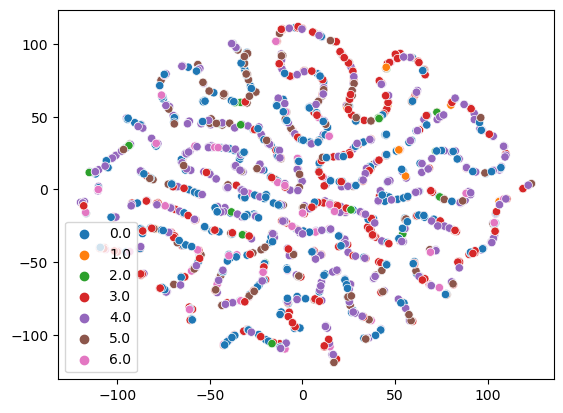

Epoch: 1 - Train Loss: 6.824262204377548


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


General - KNN F1: 0.171197056433288 Acc: 0.30891950688905
Iemocap - KNN F1: 0.12155316936546048 Acc: 0.24
Meld - KNN F1: 0.2631103019061897 Acc: 0.41155234657039713
Iemocap - KNN F1 (macro): 0.06973630476934668
Meld - KNN F1 (macro): 0.09943453856193366


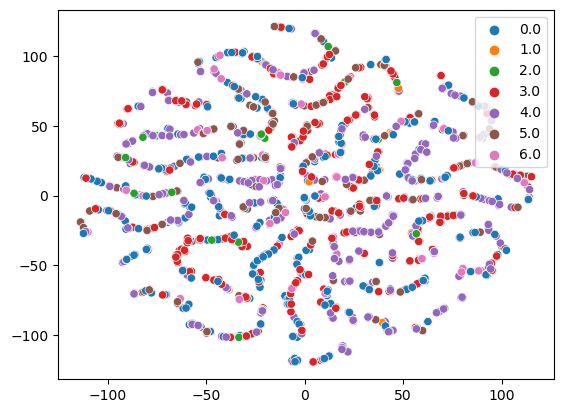

Epoch: 2 - Train Loss: 6.70646914191868


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


General - KNN F1: 0.17124372031564372 Acc: 0.3107324147933285
Iemocap - KNN F1: 0.12610321188300877 Acc: 0.24484848484848484
Meld - KNN F1: 0.25523408539934794 Acc: 0.40884476534296027
Iemocap - KNN F1 (macro): 0.08672412979953138
Meld - KNN F1 (macro): 0.09286661195631588


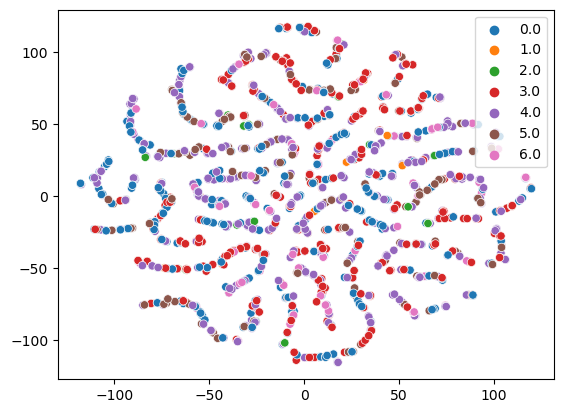

Epoch: 3 - Train Loss: 6.669884163400401


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


General - KNN F1: 0.1641896612299081 Acc: 0.30855692530819434
Iemocap - KNN F1: 0.11402878418087052 Acc: 0.2381818181818182
Meld - KNN F1: 0.2576143061740575 Acc: 0.41335740072202165
Iemocap - KNN F1 (macro): 0.06568525790077355
Meld - KNN F1 (macro): 0.09317061429943323


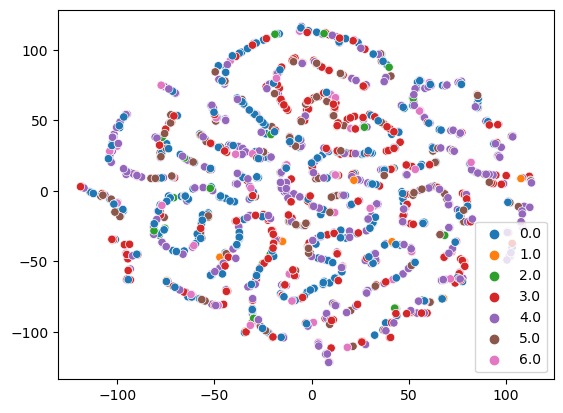

Epoch: 4 - Train Loss: 6.645169963007388


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


General - KNN F1: 0.2027659301595141 Acc: 0.31145757795503987
Iemocap - KNN F1: 0.16098787734490577 Acc: 0.2509090909090909
Meld - KNN F1: 0.2783158121111147 Acc: 0.4016245487364621
Iemocap - KNN F1 (macro): 0.11147958005635121
Meld - KNN F1 (macro): 0.11928174958289986


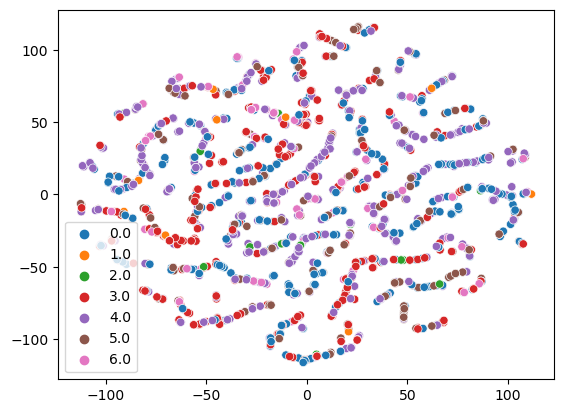

Epoch: 5 - Train Loss: 6.634081529534382


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


General - KNN F1: 0.21705631691350702 Acc: 0.30891950688905
Iemocap - KNN F1: 0.18399979466444688 Acc: 0.2545454545454545
Meld - KNN F1: 0.26625811976674674 Acc: 0.3898916967509025
Iemocap - KNN F1 (macro): 0.13706422020715764
Meld - KNN F1 (macro): 0.1158960783401612


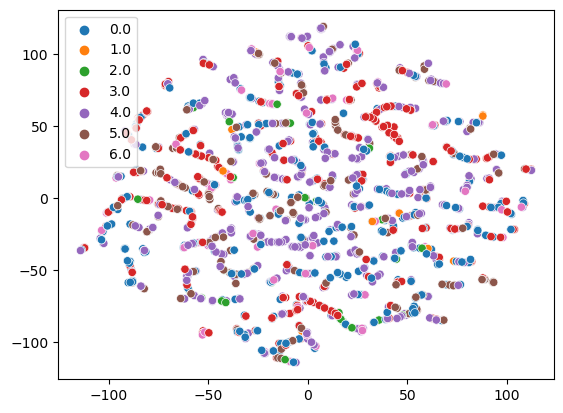

Epoch: 6 - Train Loss: 6.629844043565833


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


General - KNN F1: 0.2696033838834416 Acc: 0.31870920957215376
Iemocap - KNN F1: 0.17350518913076668 Acc: 0.2581818181818182
Meld - KNN F1: 0.2650950439322922 Acc: 0.40884476534296027
Iemocap - KNN F1 (macro): 0.1133526131448625
Meld - KNN F1 (macro): 0.10111338120513369


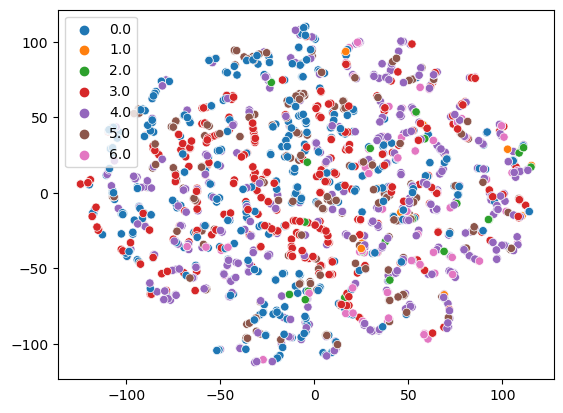

Epoch: 7 - Train Loss: 6.614016056060791


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.07s/it]


General - KNN F1: 0.28447972793041665 Acc: 0.3495286439448876
Iemocap - KNN F1: 0.1927226262109983 Acc: 0.3
Meld - KNN F1: 0.26015728365623864 Acc: 0.4232851985559567
Iemocap - KNN F1 (macro): 0.12082909092875871
Meld - KNN F1 (macro): 0.09366410531824065


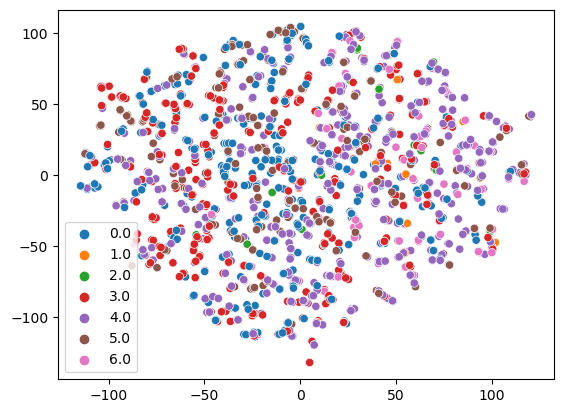

Epoch: 8 - Train Loss: 6.604461545529573


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


General - KNN F1: 0.2705951525938647 Acc: 0.32197244379985496
Iemocap - KNN F1: 0.1781519982951477 Acc: 0.2672727272727273
Meld - KNN F1: 0.2480004243233267 Acc: 0.40342960288808666
Iemocap - KNN F1 (macro): 0.11654212178180383
Meld - KNN F1 (macro): 0.087645748367157


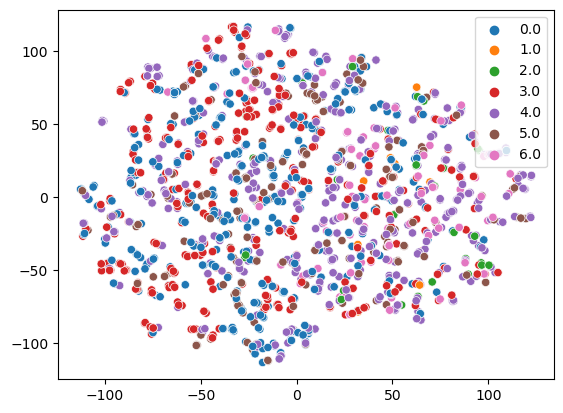

Epoch: 9 - Train Loss: 6.603634191595989


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


General - KNN F1: 0.2952757157833989 Acc: 0.36475707034082666
Iemocap - KNN F1: 0.2604558635961728 Acc: 0.3278787878787879
Meld - KNN F1: 0.2551305007259804 Acc: 0.4196750902527076
Iemocap - KNN F1 (macro): 0.17163003981266609
Meld - KNN F1 (macro): 0.08846761986944263


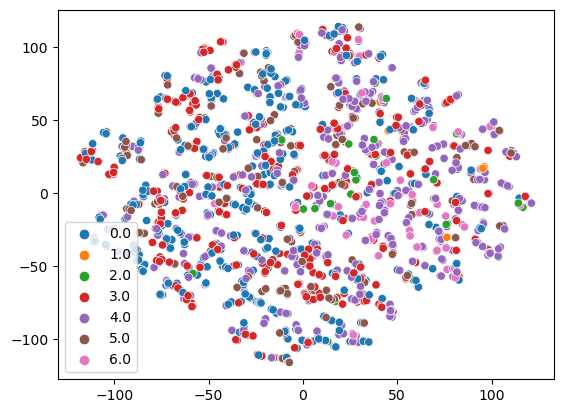

Epoch: 10 - Train Loss: 6.6043679817863135


 52%|██████████████████████████████████▍                               | 12/23 [00:57<00:51,  4.69s/it]

In [ ]:
PATH_TO_SAVE = "./audio_encoder_pre_trained_reformed_3"
!mkdir -p {PATH_TO_SAVE}

dim_embed = 64
N_CLUSTERS = 64

#pickle.dump(kmeans, open(f"{PATH_TO_SAVE}/kmeans_{N_CLUSTERS}_clusters_curr.pkl", 'wb'))

audio_encoder = AudioEncoderMFCCHU(
    None, 
    N_CLUSTERS, 
    mean, 
    std, 
    emb_dim=dim_embed, 
    n_layers=1, 
    max_length=256, 
    nheads=8,
    dropout=0.2
)

supcon_model = AudioCLIP(
    audio_encoder,
    out_features_audio=dim_embed,
    wide_proj=dim_embed*4, 
    proj_size=dim_embed, 
    rate=0.2,
)

supcon_loss = SupConLoss(temperature=0.1, contrast_mode='all', base_temperature=0.1)
supcon_model.to(0)
scaler = torch.cuda.amp.GradScaler()

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')

param_optimizer = list(supcon_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=0, betas=(0.9, 0.98), eps=1e-8)

warmup_steps=300
epochs = 9999

scheduler = Scheduler(opt, dim_embed, warmup_steps)

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []

    preds = []

    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if i == len(train_loader)-1:
            continue
        
        batch = df_train.iloc[batch_indices[0]]
        audio_paths = list(batch["path"])
        
        target = torch.Tensor(lab_encoder.transform(list(batch["label"])))
        
        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

            out, wide, vq_loss = supcon_model(audio_paths)
            out = out.unsqueeze(dim=1)
            
            loss = supcon_loss(out, labels=target) + 0.9 * vq_loss
            
        scaler.scale(loss).backward()
        scaler.unscale_(opt)

        torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 20.0)
        scaler.step(opt)
        scaler.update()
        scheduler.step()
        opt.zero_grad(set_to_none=True)

        epoch_loss += loss.item()
        proj_train.append(np.array(wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))
        
        del out
        del wide
        gc.collect()
        torch.cuda.empty_cache()
        
    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)

    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    supcon_model.eval()
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            batch = test_df_erc.iloc[batch_indices[0]]
            audio_paths = list(batch["path"])

            target = torch.Tensor(lab_encoder.transform(list(batch["label"])))

            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                _, wide, _ = supcon_model(audio_paths)

            wide = np.array(wide.cpu())
            pred = clf.predict(wide)

            assert len(wide) == len(pred)

            preds.append(pred)
            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))

            del wide
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    preds = np.array(np.concatenate(preds, axis=0))

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
    iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index
    
    general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])
    
    general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
    general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])
    
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
    
    print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
    print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")
    
    idx = np.random.randint(len(proj_val), size=2000)

    proj_val_samp = proj_val[idx, :]
    targets_val_samp = targets_val[idx]
    tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val_samp)

    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=targets_val_samp, palette='tab10')
    plt.show()

    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1 (weighted): {general_f1} Acc: {general_acc}')
        f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        
    if general_f1 > old_f1 or general_f1_iemocap > old_f1_iemocap or general_f1_meld > old_f1_meld:
        checkpoint = {"model": supcon_model.state_dict(),
                  "optimizer": opt.state_dict(),
                  "scaler": scaler.state_dict()}
        torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioCLIP_epoch_{e}.bin')

In [ ]:
dim_embed=768

audio_encoder = AudioEncoderMFCCHU(
    None, 
    128, 
    0, 
    0, 
    emb_dim=dim_embed, 
    n_layers=1, 
    max_length=384, 
    nheads=12
)

supcon_model = AudioCLIP(
    audio_encoder,
    out_features_audio=dim_embed,
    wide_proj=1024, 
    proj_size=128, 
    rate=0.1,
)

In [ ]:
audio_encoder_state = torch.load(f'./audio_encoder_pre_trained_reformed/pytorch_model_AudioCLIP_epoch_48.bin')
supcon_model.load_state_dict(audio_encoder_state['model'])

In [ ]:
torch.save(supcon_model.audio_encoder.state_dict(), f'./audio_encoder_pre_trained_reformed/audio_best.bin')

In [ ]:
audio_encoder_state['model']

In [ ]:
print(audio_paths)

In [ ]:
xxx